# Analyze raw data
I could not yet reconstruct the temperature values from solexprts out of their raw data

I also did not manage to calculate other open source raw data into temperatures.
But with more time invested and the use of `Basdetombe_2020_dts_calibration_libary.pdf` and an investigation of the code from their python library I should manage to get the results.
* [link_to_doc](https://python-dts-calibration.readthedocs.io/en/latest/readme.html#learn-by-examples)
* [link_to_github](https://github.com/dtscalibration/python-dts-calibration)

Additionally I could work with the exported data from Charon3 and try to calculate the temperature from that raw data.
Saved these in `export_PCMario`

See also `analyse_backscat.ipynb` before starting to work with this notebook again!

## this notebook is not functionally!

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
import pickle
from datetime import timedelta
import math

import plotly
import plotly.express as px
import kaleido

from my_func_mvw.functions_import_my_database import import_my_database_pickle, import_my_database_csv
from my_func_mvw.functions import read_pickle, find_nearest_date
%load_ext autoreload
%autoreload 2

importer = "pickle" #at the moment only pickle is implemented
path_to_my_database = r"..\Alsdorf\Daten\my_database" #".\\"
plot_save = True #True False

print("Some Version information of the imported packages")
print(f"pandas version: {pd.__version__}")
print(f"pickle version: {pickle.format_version}")
# Output from Mathis:
# Some Version information of the imported packages
# pandas: 1.2.3
# pickle: 4.0
# Python 3.8.8

Some Version information of the imported packages
pandas version: 1.3.2
pickle version: 4.0


In [4]:
import dtscalibration

In [5]:
# import solexperts data
# 20s
path_to_solexperts = path_to_my_database + "\Solexperts_EGRT"
filename=r"\alle Messungen_TEMP.txt"

#encoding= 'unicode_escape': for reading non asci characters
temp_sol = pd.read_csv(path_to_solexperts + filename, delimiter="\t", index_col=0, encoding= 'unicode_escape')
temp_sol.index.names = ["Length [m]"]
temp_sol.index = temp_sol.index.astype(int)
temp_sol.columns.names = ["Date"]
temp_sol.columns= pd.to_datetime(temp_sol.columns)
temp_sol = temp_sol.T

In [6]:
# import solexperts t_logger
filename = "\wagoTemperatur_korigiert.txt"
tlogger_sol = pd.read_csv(path_to_solexperts + filename, delimiter="\t", index_col=0)
tlogger_sol.columns.names = ["Dates"]
tlogger_sol.columns= pd.to_datetime(tlogger_sol.columns)
tlogger_sol.index=["Watertank"]
tlogger_sol.index.names = [""]
tlogger_sol = tlogger_sol.T

In [7]:
# import raw data
filename="\\alle_Messungen_DAEMPFUNG.txt"
raw_sol = pd.read_csv(path_to_solexperts + filename, delimiter="\t", index_col=0, na_values=[" "], dtype=float)
raw_sol.index.names = ["Length [m]"]
raw_sol.index = raw_sol.index.astype(int)
raw_sol.columns.names = ["Date"]
raw_sol.columns= pd.to_datetime(raw_sol.columns)
raw_sol = raw_sol.T
# Why is number of columns different to temperature?

#I_+ / I_-
# *-1 to egt the value of I_- / I_+

In [8]:
# seems not to be the solution
raw_sol_stretched=raw_sol.T.reindex(raw_sol.T.index.union(np.linspace(0,1644,1739)))
raw_sol_stretched=raw_sol_stretched.interpolate(method="index", axis=0)
raw_sol_stretched=raw_sol_stretched.T[np.linspace(0,1644,1739)]
raw_sol_stretched.columns=np.linspace(0,1738,1739)
raw_sol_stretched.columns=raw_sol_stretched.columns.astype(int)
#raw_sol_stretched=raw_sol_stretched.T
#raw_sol_stretched

In [9]:
# cut dataframe so it fits to raw data
x=0
col=temp_sol.columns[x:1645+x]
compare_temp_sol = temp_sol[:-47][col] #delete last dates because they are not in raw dataframe
compare_temp_sol.columns=np.arange(0,1645,1) #so column names fit to raw data
#compare_temp_sol_K = compare_temp_sol + 273.15 # macht keinen Unterschied
#compare_temp_sol

In [10]:
# Not finished - does not work good
def raw_in_temp(raw,T_ref,C):
    """"""
    T=T_ref*(1+raw/math.log(C))
    return T

from scipy.optimize import fsolve
def find_constants_for_raw_in_temp(temp_sol_array, raw_sol_array):
    """
    temp_sol_array: Two temperatures of the solexperts data
    raw_sol_array: corresponding raw values of solexperts data
    """
    #temp_sol_array=[21.732,26.158]
    #raw_sol_array=[7.288,7.184]
    def myfunction(x,temp_sol_array=temp_sol_array, raw_sol_array=raw_sol_array):#
        """x[0]: T_ref; x[1]: C"""

        array= [-1*temp_sol_array[0] + x[0] + raw_sol_array[0]*x[0]/x[1],
        -1*temp_sol_array[1] + x[0] + raw_sol_array[1]*x[0]/x[1]]

        return array

    constant_guess=[300,-8]
    constants=fsolve(myfunction, constant_guess)
    T_ref=constants[0]
    ln_C=constants[1]
    return T_ref, ln_C



26.083304984218945, 176012.80877635788


C:\Users\Mathis\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


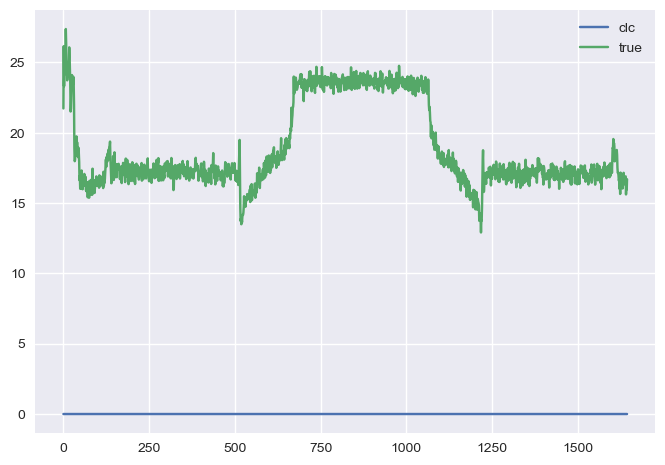

In [35]:
# funktioniert auch nicht
# date=0
# temp_sol_series=compare_temp_sol.iloc[date]
# raw_soll_sereis=raw_sol.iloc[date]
# var1, var2 = find_constants_for_raw_in_temp_neu(temp_sol_series, raw_soll_sereis)
# print(f"{var1}, {var2}")
# temp_sol_calc_me = raw_in_temp_neu(raw_soll_sereis,var1,var2)

# plt.plot(temp_sol_calc_me,label="clc")
# plt.plot(temp_sol_series,label="true")
# plt.legend()
# plt.show()

331.8924615384625, -7.79864798915499


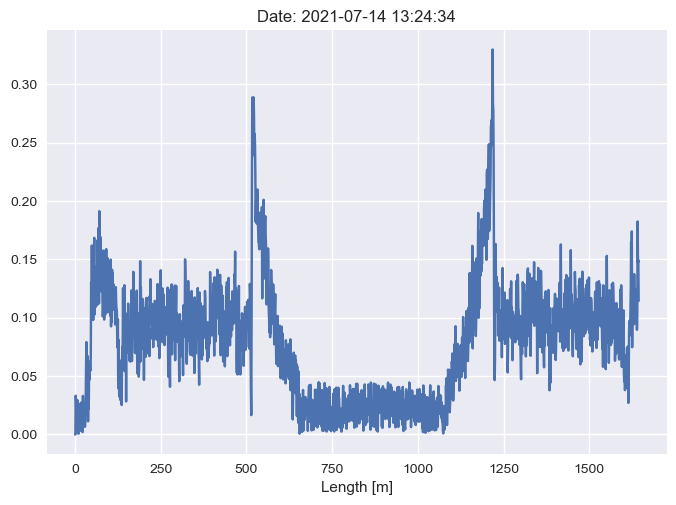

In [11]:
# use columns for constant calculation
col1=0
col2=1
date=0

temp_sol_array=np.array([compare_temp_sol.iloc[date][col1],compare_temp_sol.iloc[date][col2]])
raw_sol_array=np.array([raw_sol.iloc[date][col1],raw_sol.iloc[date][col2]])*-1
T_ref, ln_C = find_constants_for_raw_in_temp(temp_sol_array, raw_sol_array)
#(331.8924615384625, -7.79864798915499)
print(f"{T_ref}, {ln_C}")

# do calculations of constants for every date seperate
T_ref, ln_C = find_constants_for_raw_in_temp(temp_sol_array, raw_sol_array)

C=math.e**ln_C
temp_sol_calc_me = raw_in_temp(-1*raw_sol,T_ref,C) #*-1 because solexperts gave the raw data flipped on ln() compared to the used function
temp_sol_calc_me

#they somehow stretched their results?


diff = abs(temp_sol_calc_me - compare_temp_sol)
date=0
diff.iloc[date].plot()
plt.title(f"Date: {diff.iloc[date].name}")
plt.show()

# looks like raw data and temp dataframes of solexperts do not match together.
# Maybe I did not correctly math the length

349.62669717387786, -7.771029513331886


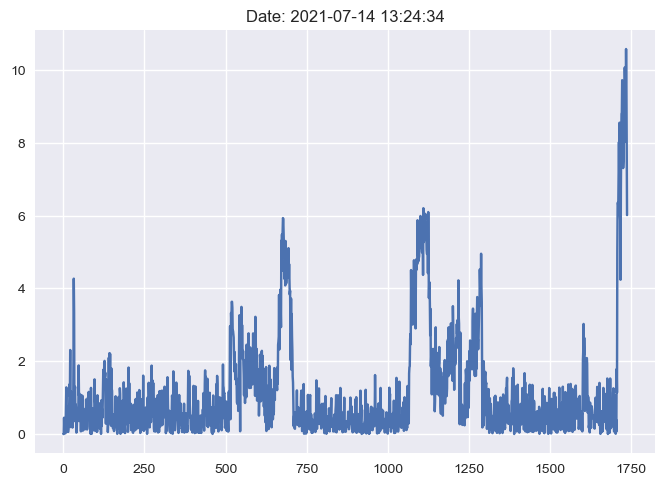

In [12]:
# Use stretched raw data
raw_sol_stretched


# use columns for constant calculation
col1=0
col2=1
date=0

temp_sol_array=np.array([temp_sol.iloc[date][col1],temp_sol.iloc[date][col2]])
raw_sol_array=np.array([raw_sol_stretched.iloc[date][col1],raw_sol_stretched.iloc[date][col2]])*-1
T_ref, ln_C = find_constants_for_raw_in_temp(temp_sol_array, raw_sol_array)
#(331.8924615384625, -7.79864798915499)
print(f"{T_ref}, {ln_C}")

# do calculations of constants for every date seperate
T_ref, ln_C = find_constants_for_raw_in_temp(temp_sol_array, raw_sol_array)

C=math.e**ln_C
temp_sol_calc_me = raw_in_temp(-1*raw_sol_stretched,T_ref,C) #*-1 because solexperts gave the raw data flipped on ln() compared to the used function
temp_sol_calc_me


diff = abs(temp_sol_calc_me - temp_sol)
date=0
diff.iloc[date].plot()
plt.title(f"Date: {diff.iloc[date].name}")
plt.show()

# Try the same with stretching the calculated temperatures

In [13]:
# how to cut the dataframe best:
analyse_cut=False
if analyse_cut:
    diff_mean={}
    for x in np.arange(0,95,1):
        #print(x)
        #x=94 #cut dataframe columns different, need to be cutted so they fit to raw datraframe
        col=temp_sol.columns[x:1645+x]
        compare_temp_sol = temp_sol[:-47][col] #delete last dates because they are not in raw dataframe
        compare_temp_sol.columns=np.arange(0,1645,1) #so column names fit to raw data
        compare_temp_sol

        # calc the temp from raw data
        temp_sol_array=np.array([compare_temp_sol.iloc[0][0],compare_temp_sol.iloc[0][1]])
        raw_sol_array=np.array([raw_sol.iloc[0][0],raw_sol.iloc[0][1]])*-1
        T_ref, ln_C = find_constants_for_raw_in_temp(temp_sol_array, raw_sol_array)
        #print(f"{T_ref},{ln_C}")
        C=math.e**ln_C

        try: # a lot of math domain errors
            temp_sol_calc_me = raw_in_temp(-1*raw_sol,T_ref,C) #*-1 because solexperts gave the raw data flipped on ln() compared to the used function

            # difference of my calculations from raw data to solexperts temperature
            diff = abs(temp_sol_calc_me - compare_temp_sol)
            diff_mean[x]=diff.iloc[0].mean()
        except:
            diff_mean[x]=np.nan

    diff_mean
    # from this analysis x=0 is by far the best option for cutting the dataframe

# Raw data from web


* Gleichung mit Paper von Delft überprüfen - erledigt
# Prozessierungscode angucken und zum laufen bringen für die Rohdaten aus Internet - MACHEN!
* Bild von Silixa nehmen welches wellenlängen abhängige attenuation mit drin hat

In [14]:
from xml.dom import minidom

# Import data
path_to_raw_online=r"..\dts_data_from_online\DTSH\level0"
filename="\\channel_1_20160316061503256.xml"

xmldoc = minidom.parse(path_to_raw_online + filename)
itemlist = xmldoc.getElementsByTagName('data')

# Date information
start_time_string=xmldoc.getElementsByTagName('startDateTimeIndex')[0].firstChild.nodeValue
end_time_string=xmldoc.getElementsByTagName('endDateTimeIndex')[0].firstChild.nodeValue
end_time=pd.to_datetime(end_time_string) #[:-10]#dont know what the last numbers are meaning, wird glaube ich gebraucht + 8 std, siehe andere ordner daten
start_time=pd.to_datetime(start_time_string)# [:-10]#dont know what the last numbers are meaning

meas_time=end_time - start_time
date = start_time + meas_time
print(date)

# Extract Data
string_values_split_2d=[]
for item in itemlist:
    string_values=item.firstChild.nodeValue
    string_values_split=string_values.split(",")
    # drop \n from strings
    string_values_split[0]=string_values_split[0][1:]
    string_values_split[-1]=string_values_split[-1][:-2]

    string_values_split_2d.append(string_values_split)

#raw_array=np.array(string_values_split_2d,dtype=float)
df=pd.DataFrame(string_values_split_2d,columns=["Length [m]","ST","AST","REV_ST","REV_AST","TMP [°C]"])
df.replace('', np.nan) #some of the first values have emtpy strings
df = df.apply(pd.to_numeric) #errors='coerce', this would add NaN, when an error occurs
df.index=df["Length [m]"]
df=df.drop("Length [m]",axis=1)
df
# rev: denke ich für revert, column ist umgedreht

2016-03-16 06:17:33.709000+00:00


,ST,AST,REV_ST,REV_AST,TMP [°C]
Length [m],,,,,
-438.639,-0.204023,0.103271,-1.369070,-0.954509,-33.5230
-437.623,-0.775841,0.005969,-0.000351,-0.991848,NaN
-436.607,0.270909,0.326099,-0.216809,-1.148590,NaN
-435.591,0.165955,0.174403,-1.421220,-0.531232,-24.7890
-434.575,-0.048758,0.558069,-0.640086,-0.357589,NaN
...,...,...,...,...,...
17735.800,881.803000,477.138000,5189.570000,4607.490000,-6.5301
17736.900,1274.090000,553.624000,6189.330000,5349.370000,-28.5280
17737.900,1665.440000,693.295000,10638.900000,8478.980000,-38.2840


In [15]:
def find_constants_for_raw_in_temp(temp_sol_array, raw_sol_array):
    """
    temp_sol_array: Two temperatures of the solexperts data
    raw_sol_array: corresponding raw values of solexperts data

    Only two datapoints are used.
    Should not better because I expect a perfect correlazion??
    """
    #temp_sol_array=[21.732,26.158]
    #raw_sol_array=[7.288,7.184]
    def myfunction(x,temp_sol_array=temp_sol_array, raw_sol_array=raw_sol_array):#
        """x[0]: T_ref; x[1]: ln(C)"""

        array= [-1*temp_sol_array.iloc[0] + x[0] + raw_sol_array.iloc[0]*x[0]/x[1],
        -1*temp_sol_array.iloc[1] + x[0] + raw_sol_array.iloc[1]*x[0]/x[1]]

        return array

    constant_guess=[52,2]
    #constant_guess=[60,4]
    constants=fsolve(myfunction, constant_guess)
    T_ref=constants[0]
    ln_C=constants[1]
    return T_ref, ln_C

def raw_in_temp(raw,T_ref,ln_C):
    """"""
    T=T_ref*(1+raw/ln_C)

    #T=T_ref*(1+diff_loss*z/ln_C+raw/ln_C)

    # ohne power seires approx und etwas anderen variablen
    # T=var1/(var2+diff_loss*z+raw) #raw=ln(I+/I-); diff_loss=alpha+ - alpha-
    #das gleiche ohne diff_loss
    T=var1/(var2+raw) #raw=ln(I+/I-); diff_loss=alpha+ - alpha-


    return T





def find_constants_for_raw_in_temp_neu(temp_true, raw_sol_array):
    """
    temp_true: Two temperatures of the solexperts data
    raw_sol_array: corresponding raw values of solexperts data raw=ln(I+/I-)

    Only two datapoints are used.
    Should not better because I expect a perfect correlazion??
    """
    #temp_sol_array=[21.732,26.158]
    #raw_sol_array=[7.288,7.184]
    def myfunction(x,temp_true=temp_true, raw_sol_array=raw_sol_array):#
        """x[0]: T_ref; x[1]: ln(C)"""

        array= [-1*temp_true.iloc[0] + x[0]/(x[1]*raw_sol_array.iloc[0]),
        -1*temp_true.iloc[1] + x[0] + x[0]/(x[1]*raw_sol_array.iloc[1])]

        return array

    constant_guess=[52,2]
    #constant_guess=[60,4]
    constants=fsolve(myfunction, constant_guess)
    var1=constants[0]
    var2=constants[1]
    return var1, var2

def raw_in_temp_neu(raw,var1,var2):
    """"""
    #T=T_ref*(1+raw/ln_C)

    #T=T_ref*(1+diff_loss*z/ln_C+raw/ln_C)

    # ohne power seires approx und etwas anderen variablen
    #T=var1/(var2+diff_loss*z+raw) #raw=ln(I+/I-); diff_loss=alpha+ - alpha-
    #das gleiche ohne diff_loss
    T=var1/(var2+raw) #raw=ln(I+/I-); diff_loss=alpha+ - alpha-
    return T

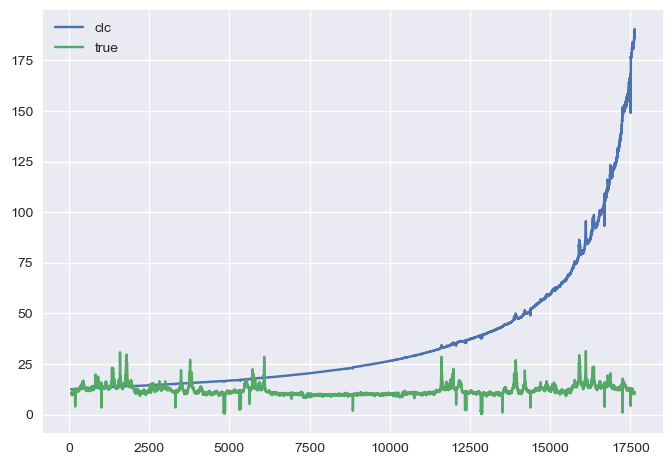

In [20]:
raw_log=np.log(df["ST"] / df["REV_AST"])
var1,var2=find_constants_for_raw_in_temp_neu(df["TMP [°C]"],raw_log)
t_clc=raw_in_temp_neu(raw_log,var1,var2)

plt.plot(t_clc.iloc[500:-100],label="clc")
plt.plot(df["TMP [°C]"].iloc[500:-100],label="true")
plt.legend()
plt.show()

In [274]:
# check if function work as expected
# highly depends on constant guess
T_ref=50
ln_C=5
true_temp=raw_in_temp(np.array([0.2,0.3]),T_ref,ln_C)
find_constants_for_raw_in_temp(pd.Series(true_temp),pd.Series([0.2,0.3]))


#      <InternalDifferentialLoss>0.024</InternalDifferentialLoss>
#      <TemperatureScalingFactor>365.000</TemperatureScalingFactor>
#     <EffectiveStokesRI>1.4758</EffectiveStokesRI>
#      <EffectiveAntiStokesRI>1.4755</EffectiveAntiStokesRI>
#           <MultiplicationFactor>0.22</MultiplicationFactor>

# channel 1 bis 4 alle
#        <DifferentialLoss>0.0460</DifferentialLoss>

(50.0, 4.999999999999998)

NameError: name 'np' is not defined

In [276]:
raw_log=np.log(df["AST"] / df["ST"])
# find_constants_for_raw_in_temp(df["TMP [°C]"],raw_log) #.iloc[500:-10]

t_clc=raw_in_temp(raw_log,365.0,0.22)
t_clc[500:]

Length [m]
500.054        67.365628
501.070        67.149285
502.086        66.129708
503.102        66.753011
504.118        69.268607
                ...     
17735.800    -653.952114
17736.900   -1017.855129
17737.900   -1089.009085
17738.900    -950.125626
17739.900    -933.191601
Length: 16971, dtype: float64

In [ ]:
T=T_ref*(1+raw/ln_C)

In [230]:
raw_log

Length [m]
-438.639           NaN
-437.623           NaN
-436.607           NaN
-435.591           NaN
-434.575           NaN
                ...   
 17735.800   -2.386600
 17736.900   -2.414096
 17737.900   -2.730817
 17738.900   -2.785683
 17739.900   -2.898132
Length: 17895, dtype: float64

C:\Users\Mathis\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Mathis\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(9.0, 11.0)

In [261]:
raw_log

Length [m]
-438.639           NaN
-437.623           NaN
-436.607      0.185418
-435.591      0.049652
-434.575           NaN
                ...   
 17735.800   -0.614163
 17736.900   -0.833502
 17737.900   -0.876389
 17738.900   -0.792678
 17739.900   -0.782472
Length: 17895, dtype: float64

Length [m]
-438.639           NaN
-437.623           NaN
-436.607      9.151706
-435.591      9.040624
-434.575           NaN
                ...   
 17735.800    8.497503
 17736.900    8.318044
 17737.900    8.282954
 17738.900    8.351445
 17739.900    8.359796
Length: 17895, dtype: float64

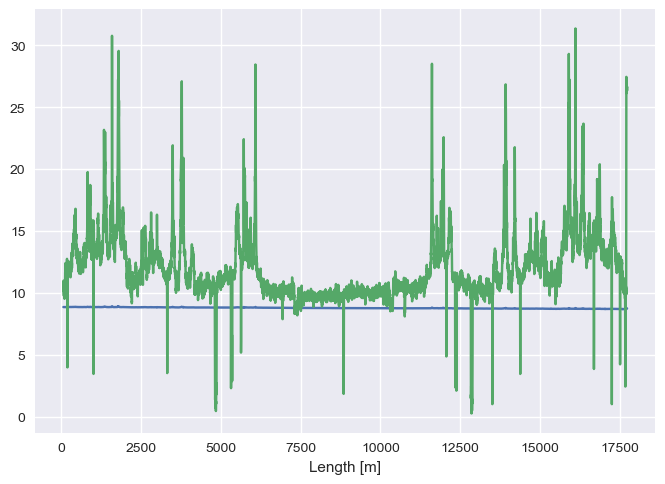

In [250]:
t_clc.iloc[500:-10].plot()
df["TMP [°C]"].iloc[500:-10].plot()
plt.show()

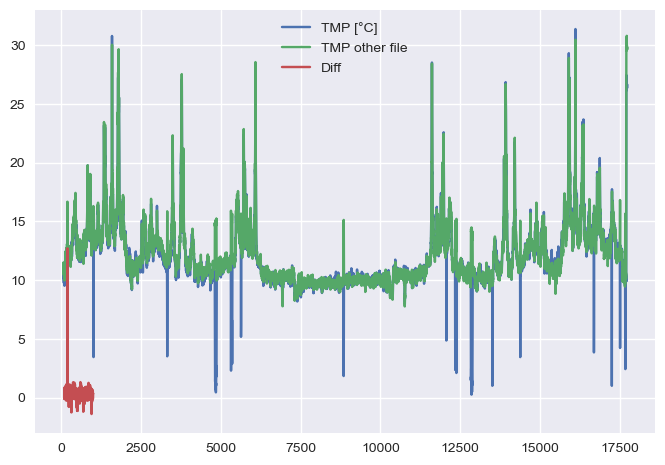

In [206]:
# plt.plot(df["ST"].index,df["ST"].values,label="ST")
# plt.plot(df["AST"].index,df["AST"].values,label="AST")
# plt.plot(df["REV_ST"].index,df["REV_ST"].values,label="REV_ST")
#diff=df["ST"]-df["REV_ST"]
#diff.plot()

plt.plot(df["TMP [°C]"].index[500:-10],df["TMP [°C]"].values[500:-10],label="TMP [°C]")
col=df_other_file.columns[50]
plt.plot(df_other_file[col].iloc[500:-10].index,df_other_file[col].iloc[500:-10].values,label="TMP other file")
diff=df_other_file[col].iloc[500:-10]-df["TMP [°C]"].iloc[500:-10] #müsste index anpassen
plt.plot(diff.index,diff.values,label="Diff")
plt.legend()
plt.show()

In [192]:
# Temp data from different file
path=r"..\dts_data_from_online\DTSH\level1"
filename="\\Porotomo20160311_TrenchCable_DTS_data.csv"
df_other_file=pd.read_csv(path + filename,skiprows=[1],index_col=[0],dtype=float)
df_other_file.index.names=["Length[m]"]
df_other_file.columns=pd.to_datetime(df_other_file.columns)
df_other_file

,2016-11-03 17:56:55,2016-11-03 18:01:57,2016-11-03 18:06:58,2016-11-03 18:11:59,2016-11-03 18:17:01,2016-11-03 18:22:03,2016-11-03 18:27:05,2016-11-03 18:32:06,2016-11-03 18:37:07,2016-11-03 18:42:09,...,2016-11-03 23:08:29,2016-11-03 23:13:31,2016-11-03 23:18:33,2016-11-03 23:23:35,2016-11-03 23:28:37,2016-11-03 23:33:39,2016-11-03 23:38:41,2016-11-03 23:43:42,2016-11-03 23:48:43,2016-11-03 23:53:46
Length[m],,,,,,,,,,,,,,,,,,,,,
-438.639,-95.320,62.535,103.348,87.853,25.307,0.000,-81.528,0.000,21.228,386.097,...,-36.570,0.536,145.614,-11.182,0.000,-24.784,541.830,271.812,0.000,0.000
-437.623,276.667,234.083,0.000,1654.680,212.002,32.427,-65.398,106.307,-91.747,-30.821,...,642.683,104.350,0.000,0.000,440.684,107.920,0.000,0.000,319.505,-74.995
-436.607,-195.139,158.849,137.234,0.000,1666.920,39.370,0.426,0.000,425.768,0.000,...,0.000,42.625,-130.816,109.682,-159.341,107.475,146.744,624.687,20.459,117.668
-435.591,-153.456,-2.013,141.072,0.000,-60.052,521.287,254.236,257.654,508.980,32.098,...,188.501,-134.802,-95.517,29.794,-57.867,0.000,0.000,0.000,-192.514,0.000
-434.575,52.252,114.576,-145.729,0.000,246.310,0.000,0.000,43.910,443.259,141.046,...,0.000,24.787,1666.820,277.106,-40.816,202.364,148.532,209.773,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17735.835,-6.251,-8.128,-5.405,-1.014,-3.802,-6.745,-6.955,-6.128,-4.325,-2.856,...,-8.952,-9.174,-8.213,-8.621,-7.543,-2.128,-1.112,-3.521,-4.112,-5.657
17736.851,-30.470,-33.429,-31.796,-29.143,-30.491,-32.939,-34.576,-30.633,-28.862,-27.421,...,-32.218,-32.198,-30.091,-30.433,-33.499,-34.204,-33.013,-35.687,-34.605,-34.714
17737.866,-47.871,-53.089,-50.291,-48.481,-47.085,-47.913,-49.642,-43.808,-40.812,-36.233,...,-35.885,-35.227,-33.321,-32.578,-42.376,-50.327,-50.086,-52.261,-50.557,-51.169
